In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

In [93]:
daily_sales = pd.read_csv("daily_sales_.csv")

In [94]:
daily_sales

,Date,Units Sold
0,2022-01-01,10149
1,2022-01-02,10051
2,2022-01-03,10379
3,2022-01-04,10732
4,2022-01-05,10294
...,...,...
726,2023-12-28,14640
727,2023-12-29,14828
728,2023-12-30,14653
729,2023-12-31,14673


<Axes: >

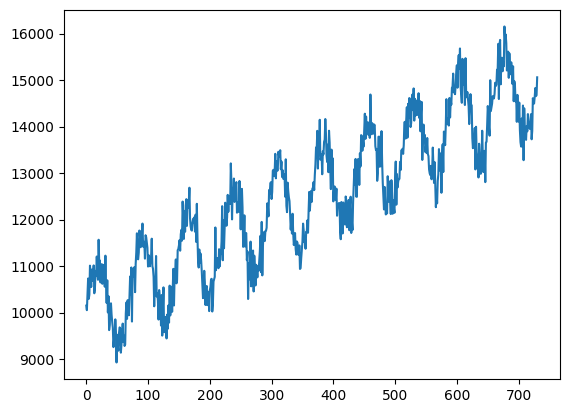

In [95]:
daily_sales["Units Sold"].plot()

In [96]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_sales[['Units Sold']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape

((560, 30, 1), (141, 30, 1))

In [97]:
scaled_data.shape

(731, 1)

Epoch 1/200


c:\Users\ali_e\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0998 - val_loss: 0.0068
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0108 - val_loss: 0.0081
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0082 - val_loss: 0.0037
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0053 - val_loss: 0.0070
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

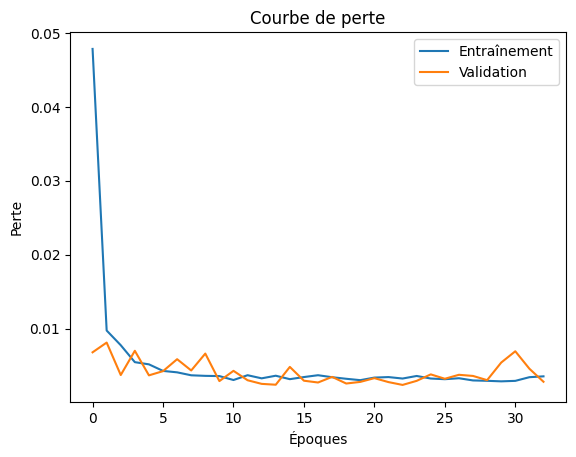

In [98]:
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.1,callbacks=[early_stopping])

plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de perte')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


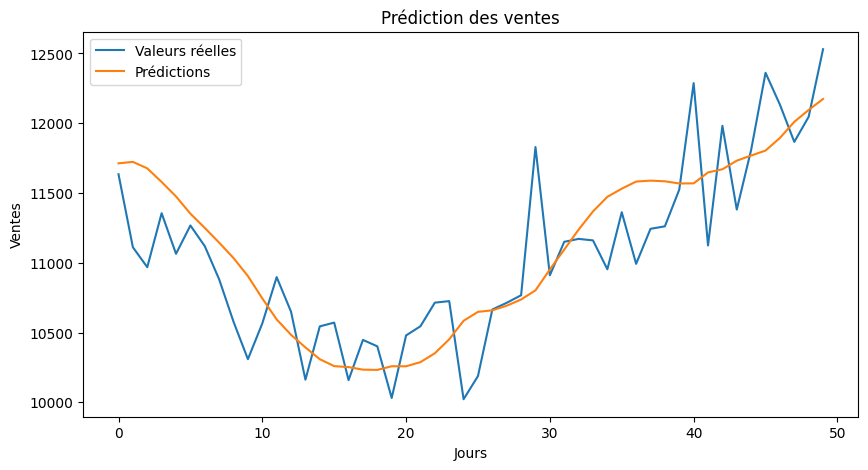

In [99]:
predictions = model.predict(X_train[150:200])
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_train[150:200])

plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Valeurs réelles')
plt.plot(predictions_rescaled, label='Prédictions')
plt.title('Prédiction des ventes')
plt.xlabel('Jours')
plt.ylabel('Ventes')
plt.legend()
plt.show()


In [100]:
X_test.shape

(141, 30, 1)

In [101]:
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f"MSE (LSTM) : {mse:.2f}")
print(f"MAE (LSTM) : {mae:.2f}")

MSE (LSTM) : 132110.27
MAE (LSTM) : 291.24


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1094.043, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1245.555, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1195.013, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1207.907, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1244.358, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1185.132, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1085.651, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1092.901, Time=0.23 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

B

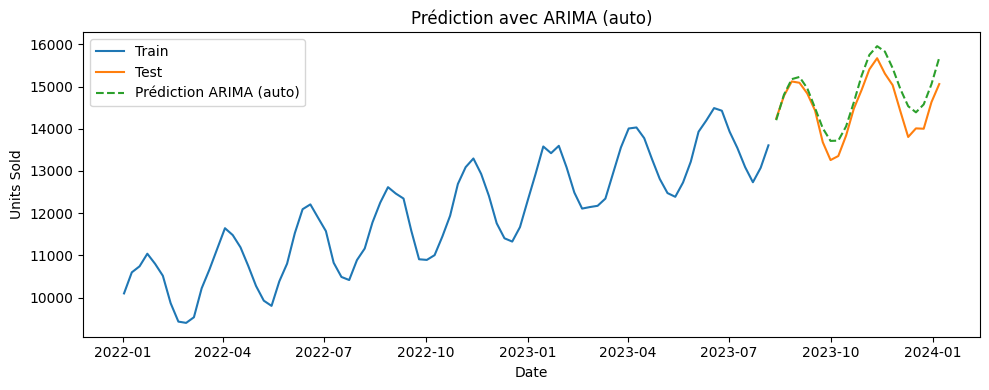

In [103]:
df = pd.read_csv('daily_sales_.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

weekly_data = df['Units Sold'].resample('W').mean()

train_size = int(len(weekly_data) * 0.8)
train, test = weekly_data[:train_size], weekly_data[train_size:]

model_auto = auto_arima(train, seasonal=False, stepwise=True, trace=True,
                        error_action='ignore', suppress_warnings=True, max_p=5, max_q=5, max_d=2)

print("Meilleur modèle trouvé :", model_auto.summary())

forecast = model_auto.predict(n_periods=len(test))

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}')

plt.figure(figsize=(10, 4))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Prédiction ARIMA (auto)', linestyle='--')
plt.title("Prédiction avec ARIMA (auto)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


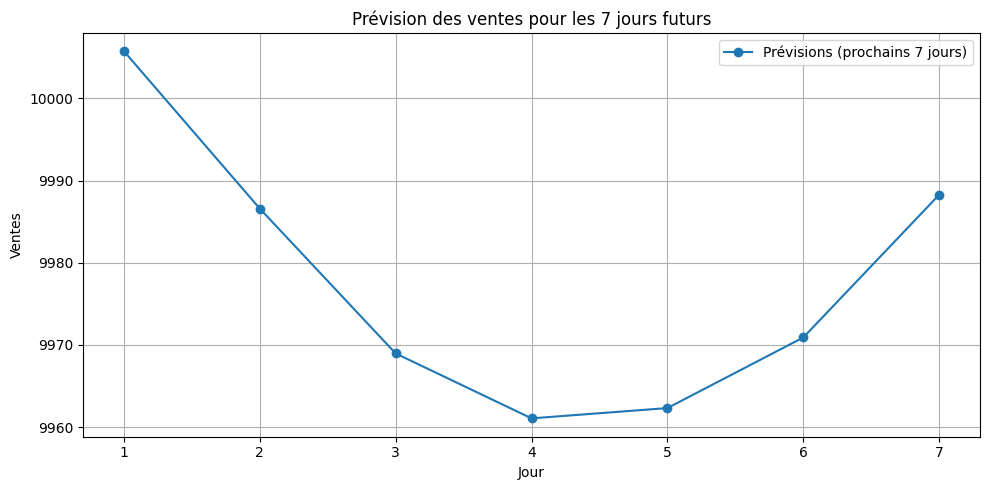

In [104]:
last_30_days = scaled_data[95:125] 
pred_input = last_30_days.reshape(1, seq_length, 1)  

future_predictions = []

for _ in range(7):  
    next_pred_scaled = model.predict(pred_input)[0][0] 
    future_predictions.append(next_pred_scaled)

    next_input = np.append(pred_input[0][1:], [[next_pred_scaled]], axis=0)
    pred_input = next_input.reshape(1, seq_length, 1)

future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 8), future_predictions_real, marker='o', label="Prévisions (prochains 7 jours)")
plt.xlabel("Jour")
plt.ylabel("Ventes")
plt.title("Prévision des ventes pour les 7 jours futurs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
